##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Artistic Style Transfer with TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/style_transfer/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

One of the most exciting developments in deep learning to come out recently is [artistic style transfer](https://arxiv.org/abs/1508.06576), or the ability to create a new image, known as a [pastiche](https://en.wikipedia.org/wiki/Pastiche), based on two input images: one representing the artistic style and one representing the content.

![Style transfer example](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/formula.png)

Using this technique, we can generate beautiful new artworks in a range of styles.

![Style transfer example](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/table.png)

This tutorial shows how to use a pre-trained TensorFlow Lite model to apply style transfer on any pair of content and style image. You can use the pre-trained model to add style transfer to your own mobile applications.

The model is open-sourced on [GitHub](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization#train-a-model-on-a-large-dataset-with-data-augmentation-to-run-on-mobile). You can retrain the model with different parameters (e.g. increase content layers' weights to make the output image look more like the content image).

## Understand the model architecture

![Model Architecture](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/architecture.png)

This Artistic Style Transfer model consists of two submodels:
1. **Style Prediciton Model**: A MobilenetV2-based neural network that takes an input style image to a 100-dimension style bottleneck vector.
1. **Style Transform Model**: A neural network that takes apply a style bottleneck vector to a content image and creates a stylized image.

If your app only needs to support a fixed set of style images, you can compute their style bottleneck vectors in advance, and exclude the Style Prediction Model from your app's binary.

## Setup

Import dependencies.

In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [18]:
try:
  # %tensorflow_version only exists in Colab.
  import tensorflow.compat.v2 as tf
except Exception:
  pass
tf.enable_v2_behavior()

In [19]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

Download the content and style images, and the pre-trained TensorFlow Lite models.

In [20]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1574914024481&di=cc15df92b155f3f0709440d6dcd723c8&imgtype=0&src=http%3A%2F%2Fwww.d1net.com%2Fuploadfile%2F2016%2F0519%2F20160519110211750.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style14.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/style_predict_quantized_256.tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/style_transfer_quantized_dynamic.tflite')

## Pre-process the inputs

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.
* The content image can be any size. However, as we trained the model using square-cropped data, cropping the content image to a square results in better stylized image.

In [21]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process style image input.
def preprocess_style_image(style_image):
  # Resize the image so that the shorter dimension becomes 256px.
  target_dim = 256
  shape = tf.cast(tf.shape(style_image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  style_image = tf.image.resize(style_image, new_shape)

  # Central crop the image.
  style_image = tf.image.resize_with_crop_or_pad(style_image, target_dim, target_dim)

  return style_image

# Function to pre-process content image input.
def preprocess_content_image(content_image):
  # Central crop the image.
  shape = tf.shape(content_image)[1:-1]
  short_dim = min(shape)
  content_image = tf.image.resize_with_crop_or_pad(content_image, short_dim, short_dim)

  return content_image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_content_image(content_image)
preprocessed_style_image = preprocess_style_image(style_image)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 849, 849, 3)


## Visualize the inputs

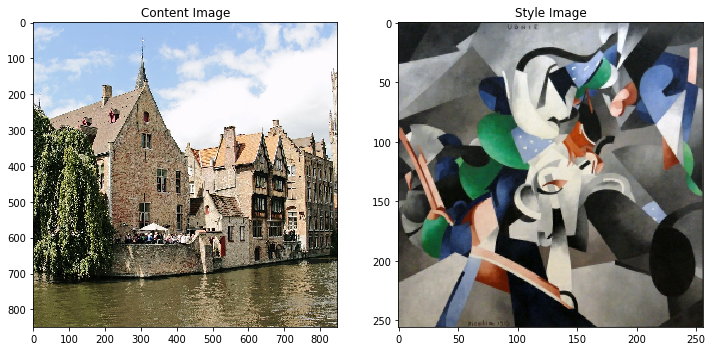

In [22]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

## Run style transfer with TensorFlow Lite

### Style prediction

In [23]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


### Style transform

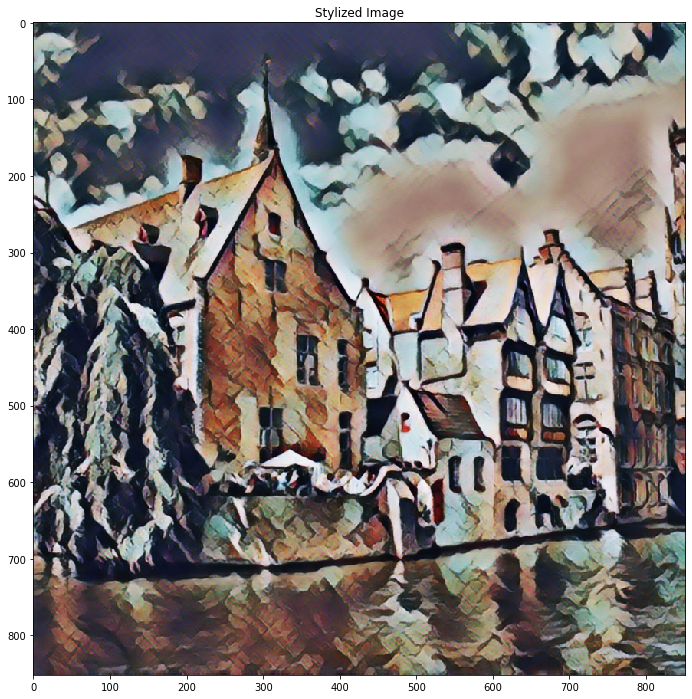

In [24]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.resize_tensor_input(input_details[0]["index"],
                                  preprocessed_content_image.shape)
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

### Style blending

We can blend the style of content image into the stylized output, which in turn making the output look more like the content image.

In [25]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_style_image(content_image)
    )

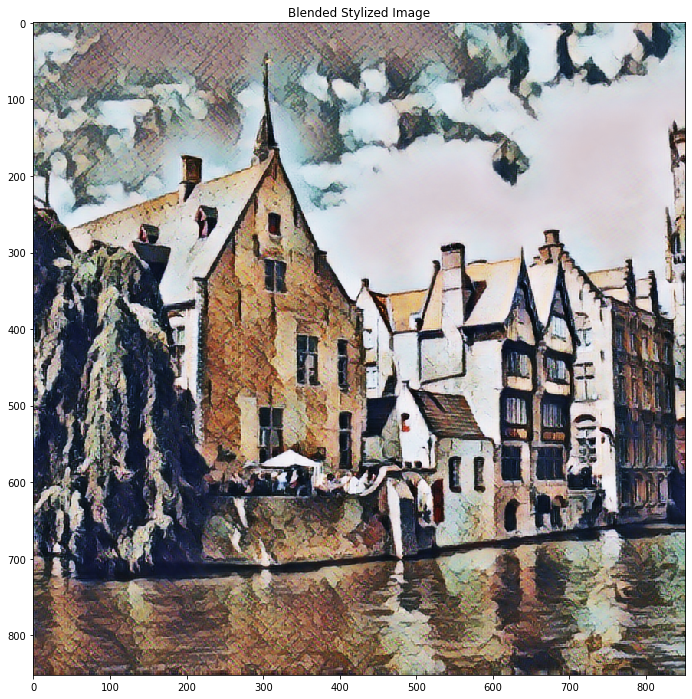

In [26]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

## Performance Benchmarks

Performance benchmark numbers are generated with the tool [described here](https://www.tensorflow.org/lite/performance/benchmarks).
<table ><thead><tr><th>Model name</th> <th>Model size</th>  <th>Device </th> <th>NNAPI</th> <th>CPU</th></tr> </thead> 
<tr> <td rowspan = 3> <a href="https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/style_predict_quantized_256.tflite">Style prediction model</a> </td> 
<td rowspan = 3>2.8 Mb</td>
<td>Pixel 3 (Android 10) </td> <td>142ms</td><td>14ms*</td></tr>
<tr><td>Pixel 4 (Android 10) </td> <td>5.2ms</td><td>6.7ms*</td></tr>
<tr><td>iPhone XS (iOS 12.4.1) </td> <td></td><td>10.7ms**</td></tr>
<tr> <td rowspan = 3> <a href="https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/style_transfer_quantized_dynamic.tflite">Style transform model</a> </td> 
<td rowspan = 3>0.2s Mb</td>
<td>Pixel 3 (Android 10) </td> <td></td><td>540ms*</td></tr>
<tr><td>Pixel 4 (Android 10) </td> <td></td><td>405ms*</td></tr>
<tr><td>iPhone XS (iOS 12.4.1) </td> <td></td><td>251ms**</td></tr></table>
* 4 threads used.

** 2 threads on iPhone for the best performance.

